In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

In [2]:
%run -i financial_sector_functions.py

/home/luke/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [4]:
data = pd.read_csv("financial_sector_clean_return_space_Dec_13.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)
sector_return = data.iloc[:,[0]]
x_data = data.iloc[:,1:]
sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

sector_beat_benchmark = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index,columns = ['IFY beat benchmark'])

In [6]:
def logistic_fit_function(x,y,nunmber_of_years_lookback,month_forecast,lambda_value,penalty_type ='l2'):
    logistic_result_dict = {}
    coef_all_df = pd.DataFrame()
    accuracy_dict = {}
    y_prediction_dict ={}
    number_of_runs = 0.0
    for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
        begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
        selection = (x.index>=begin_index) & (x.index <= end_index)
        spliced_x = x[selection]
        spliced_y = y[selection]

        assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
        logistic  = LogisticRegression(penalty=penalty_type, C = 1/float(lambda_value))
        logistic.fit(spliced_x,spliced_y)

        test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
        test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
        test_x = x[test_selection]
        test_y = y[test_selection]
        assert(len(test_y)==month_forecast)
        y_prediction = pd.DataFrame(logistic.predict(test_x),index = test_y.index,columns = test_y.columns)

        y_prediction_dict[dt_index] = y_prediction
        accuracy_df = ((y_prediction-test_y)==0)*1
        accuracy_dict[dt_index] = accuracy_df
        number_of_runs +=1

    mean_accuracy_list = []
    for key,value in accuracy_dict.iteritems():
        mean_accuracy_list.append((value.values.flatten()))
    return np.mean(mean_accuracy_list)

In [7]:

# nunmber_of_years_lookback = 10
# month_forecast = 3

# forecast_3m = pd.DataFrame()
# for years in range(3,11):
#     for lambda_value in np.linspace(0.1,10,10):
#         accuracy = logistic_fit_function(x=x_data,y=sector_beat_benchmarks
#                                          ,nunmber_of_years_lookback = years,
#                                          month_forecast = 3,lambda_value = lambda_value)
#         forecast_3m.loc[str(years)+' years',str(lambda_value)]=accuracy

In [8]:
# print(np.max(forecast_3m.values))
# np.round(forecast_3m,3)

In [9]:
# fig_size = 15,5

# plot=forecast_3m.T.plot(figsize = fig_size,grid = True,
#                         title = "Accuracy for forecasting 3 months ahead with different lookback period")
# plot.set_xlabel("lambda")
# plot.set_ylabel("Accuracy")
# plt.savefig('logistic_acf_3month_result.png')
# max_acf = np.max(forecast_3m.values)
# plt.text(6,0.505,"Max accuracy: "+str(round(max_acf,3)),fontdict ={'size':12})
# plt.show()

array([ 0.005,  0.015,  0.025,  0.035,  0.045,  0.055,  0.065,  0.075,
        0.085,  0.095,  0.105,  0.115,  0.125,  0.135,  0.145,  0.155,
        0.165,  0.175,  0.185,  0.195,  0.205,  0.215,  0.225,  0.235,
        0.245,  0.255,  0.265,  0.275,  0.285,  0.295,  0.305,  0.315,
        0.325,  0.335,  0.345,  0.355,  0.365,  0.375,  0.385,  0.395,
        0.405,  0.415,  0.425,  0.435,  0.445,  0.455,  0.465,  0.475,
        0.485,  0.495])

In [119]:
def change_month_horizon(x,y,month_looking_forward,save_fig = False,additional_text=None,png_dir=None):
    forecast_df = pd.DataFrame()
    for years in range(3,11):
        for lambda_value in  np.arange(5,500,10)/1000.0:
            accuracy = logistic_fit_function(x=x,y=y,
                                             nunmber_of_years_lookback = years,
                                             month_forecast = month_looking_forward,
                                             lambda_value = lambda_value)
            forecast_df.loc[str(years)+' years',str(lambda_value)]=accuracy
            
    fig_size = 15,5
    title_name = "Accuracy for forecasting "+ str(month_looking_forward) +" months ahead with different lookback period"
    file_name = "logistic_acf"+str(month_looking_forward)+"M"
    if png_dir:
        file_name = png_dir+file_name
    if additional_text:
        file_name += additional_text
        title_name += "("+additional_text+")"

    df_plot = forecast_df.T.plot(figsize = fig_size,grid = True,title=title_name)
    patches, labels = df_plot.get_legend_handles_labels()
    df_plot.legend(patches, labels, loc=4)
    df_plot.set_xlabel("lambda")
    df_plot.set_ylabel("Accuracy")
    max_acf = np.max(forecast_df.values)
    max_year, max_lambda = forecast_df.T.max(axis=0).idxmax(),forecast_df.T.max(axis=1).idxmax()
    plt.text(25,0.52,"Max accuracy: "+str(round(max_acf,3))+" ("+max_year+", "+max_lambda+")",fontdict ={'size':12})
    if save_fig:
        plt.savefig(file_name+".png")
    plt.show()
    print(month_looking_forward)
    print(np.round(np.max(forecast_df.values),3))

best: 58 percent
5 years lookback with 3 month forecasting

In [50]:
# x = x_data
# y = sector_beat_benchmark
# nunmber_of_years_lookback = 5
# month_forecast = 3
# lambda_value = 3.5


# logistic_result_dict = {}
# coef_all_df = pd.DataFrame()
# accuracy_dict = {}
# y_prediction_dict ={}
# prob_dict ={}
# number_of_runs = 0.0
# for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
#     begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
#     selection = (x.index>=begin_index) & (x.index <= end_index)
#     spliced_x = x[selection]
#     spliced_y = y[selection]

#     assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
#     logistic  = LogisticRegression(penalty='l2', C = 1/float(lambda_value))
#     logistic.fit(spliced_x,spliced_y)

#     test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
#     test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
#     test_x = x[test_selection]
#     test_y = y[test_selection]
#     assert(len(test_y)==month_forecast)
#     y_prediction = pd.DataFrame(logistic.predict(test_x),index = test_y.index,columns = test_y.columns)
#     prb_values = [prob_list[1] for prob_list in logistic.predict_proba(test_x)]
#     prob_dict[str(dt_index.date())]=pd.DataFrame(prb_values, index = test_y.index)
#     y_prediction_dict[dt_index] = y_prediction
#     accuracy_df = ((y_prediction-test_y)==0)*1
#     accuracy_dict[str(dt_index.date())] = accuracy_df
#     number_of_runs +=1

# mean_accuracy_list = []
# for key,value in accuracy_dict.iteritems():
#     mean_accuracy_list.append((value.values.flatten()))
    
# concat_df = pd.DataFrame()
# for key in np.sort(prob_dict.keys()):
#     value = prob_dict[key]
#     concat_df = pd.concat([concat_df,value],1)
# clean_df = pd.DataFrame()
# for index in concat_df.index:
#     temp = concat_df.loc[index,:].dropna()
#     temp = pd.DataFrame(temp).T
#     temp.columns = range(len(temp.columns))
#     clean_df = pd.concat([clean_df,temp])

In [51]:
# plt.figure(figsize = (15,7))
# plt.grid()
# pred_1,pred_2,pred_3,=plt.plot(clean_df,'b.')
# real_y,=plt.plot(y,'k-',alpha = 0.5)
# base,=plt.plot(y.index,np.repeat(0.5,len(y)),'r-')
# plt.legend([pred_1,real_y,base],['prediction','real','base'],loc=2)
# ttl = plt.title("Logistic Regression, 5 year lookback predicting 3 months ahead (Accuracy = 0.58)",fontsize = 15)
# ttl.set_position([.5, 1.05])
# plt.savefig("Logistic_regression_5year_3months_result.png")
# plt.show()

In [ ]:
x,y,month_looking_forward,save_fig = False,additional_text=None,png_dir=None

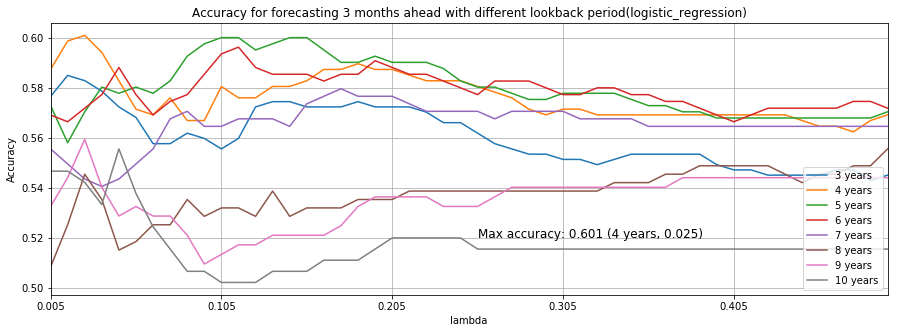

3
0.601


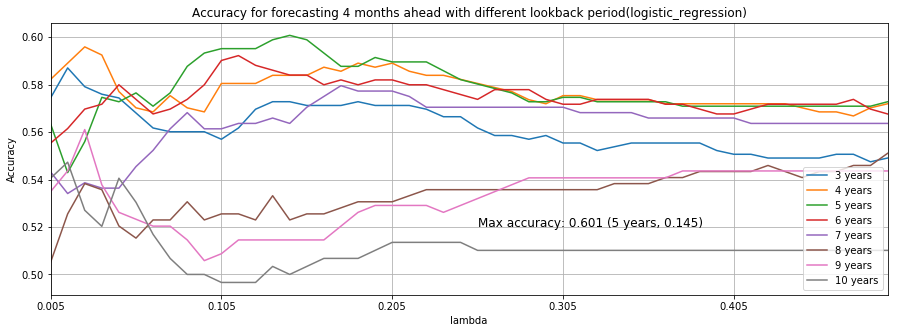

4
0.601


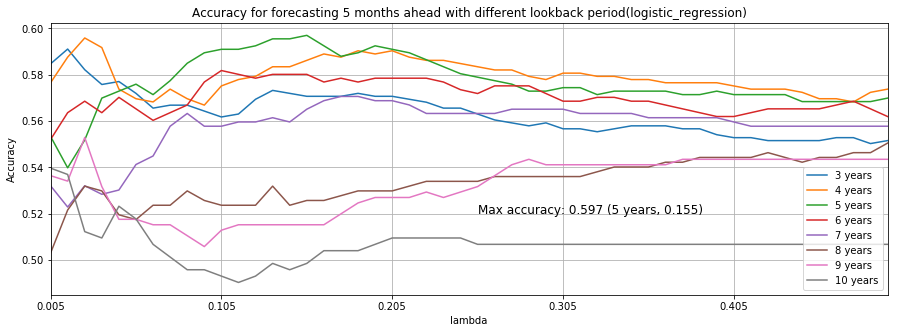

5
0.597


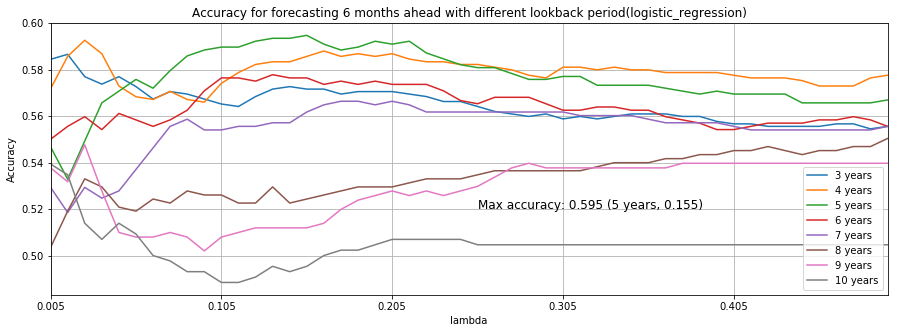

6
0.595


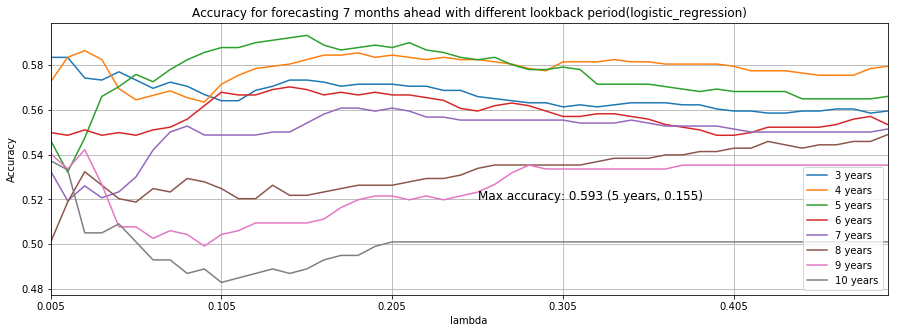

7
0.593


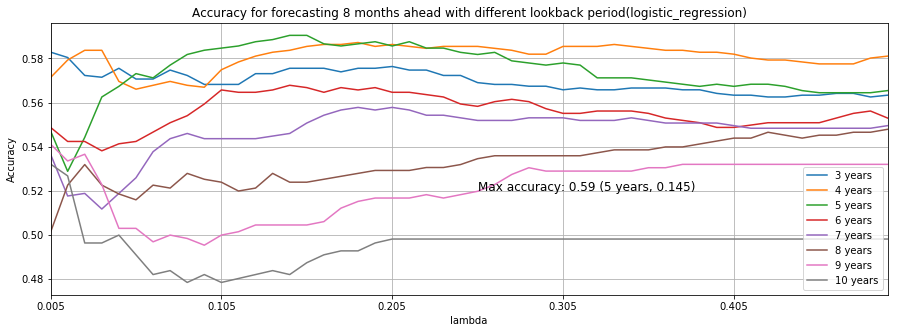

8
0.59


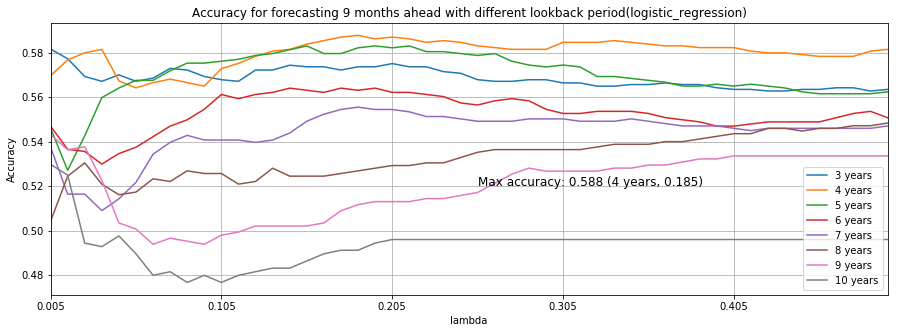

9
0.588


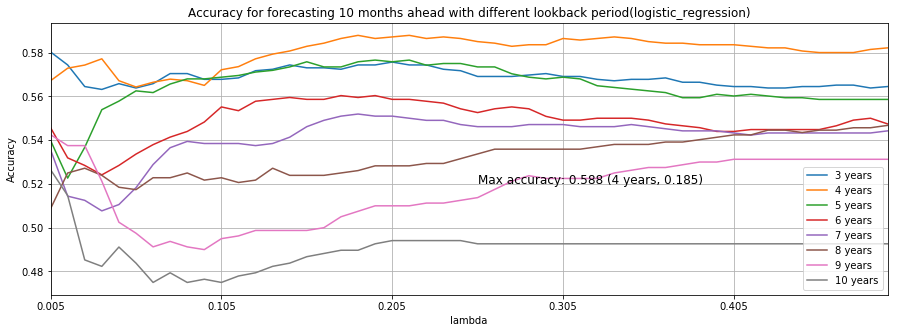

10
0.588


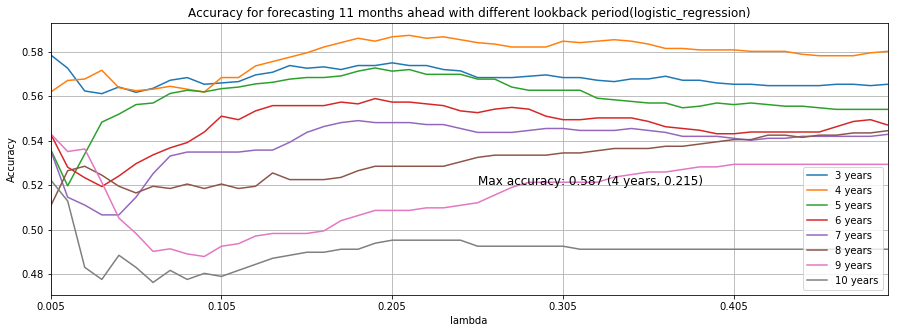

11
0.587


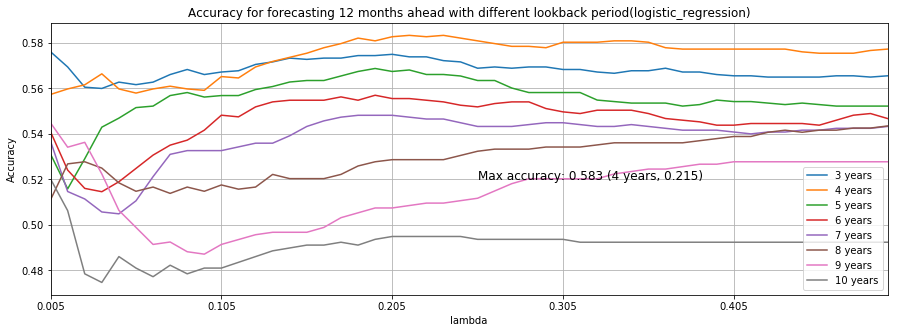

12
0.583


In [120]:
logistic_png_dir = '/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/logistic_png/'
for month in np.arange(3,12+1):
    change_month_horizon(x=x_data,y=sector_beat_benchmark,month_looking_forward=month,
                         save_fig = True,additional_text = "logistic_regression",png_dir = logistic_png_dir)

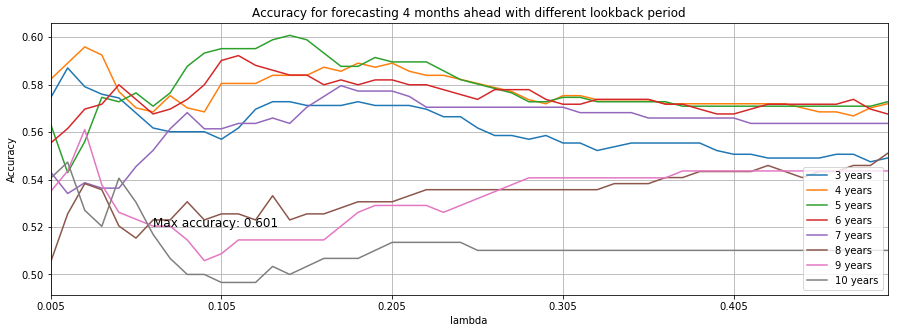

4
0.601


In [52]:
# x=x_data
# y=sector_beat_benchmark
# month_looking_forward=month
# save_fig = False
# additional_text =None
# png_dir=None

# forecast_df = pd.DataFrame()
# for years in range(3,11):
#     for lambda_value in  np.arange(5,500,10)/1000.0:
#         accuracy = logistic_fit_function(x=x,y=y,
#                                          nunmber_of_years_lookback = years,
#                                          month_forecast = month_looking_forward,
#                                          lambda_value = lambda_value)
#         forecast_df.loc[str(years)+' years',str(lambda_value)]=accuracy



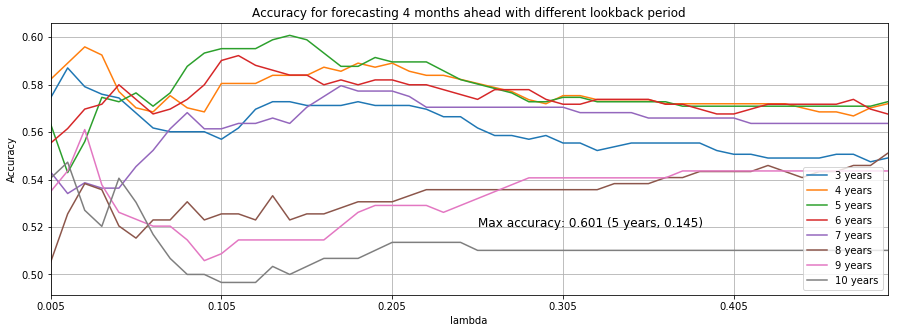

4
0.601


In [121]:
fig_size = 15,5
title_name = "Accuracy for forecasting "+ str(month_looking_forward) +" months ahead with different lookback period"
file_name = "logistic_acf"+str(month_looking_forward)+"M"
if png_dir:
    file_name = png_dir+file_name
if additional_text:
    file_name += additional_text
    title_name += "("+additional_text+")"

df_plot = forecast_df.T.plot(figsize = fig_size,grid = True,title=title_name)

patches, labels = df_plot.get_legend_handles_labels()
df_plot.legend(patches, labels, loc=4)

df_plot.set_xlabel("lambda")
df_plot.set_ylabel("Accuracy")
max_acf = np.max(forecast_df.values)
max_year, max_lambda = forecast_df.T.max(axis=0).idxmax(),forecast_df.T.max(axis=1).idxmax()
plt.text(25,0.52,"Max accuracy: "+str(round(max_acf,3))+" ("+max_year+", "+max_lambda+")",fontdict ={'size':12})
if save_fig:
    plt.savefig(file_name+".png")
plt.show()
print(month_looking_forward)
print(np.round(np.max(forecast_df.values),3))

best : 59
8 year look back, 3 month 

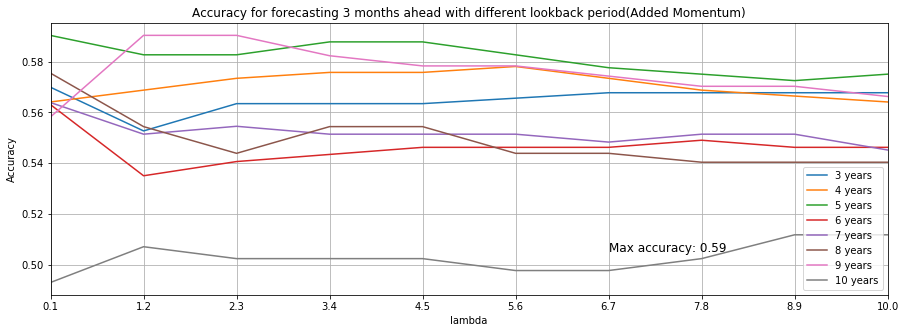

3
0.59


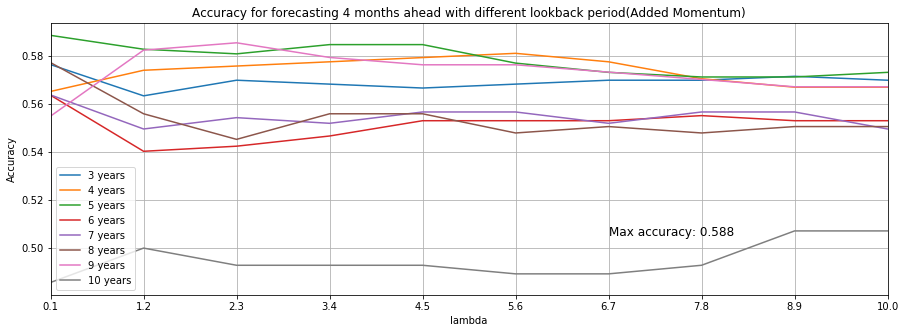

4
0.588


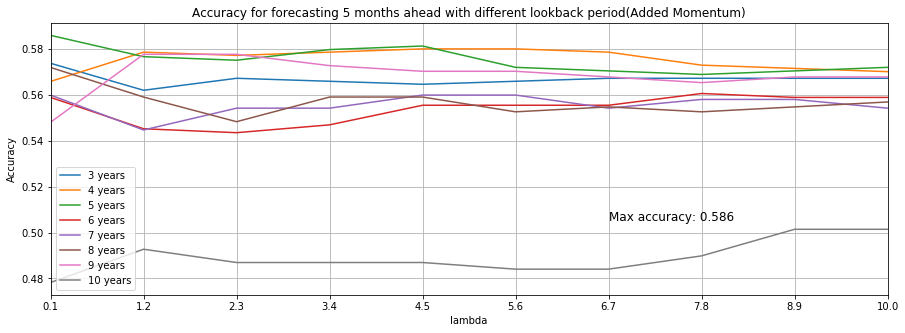

5
0.586


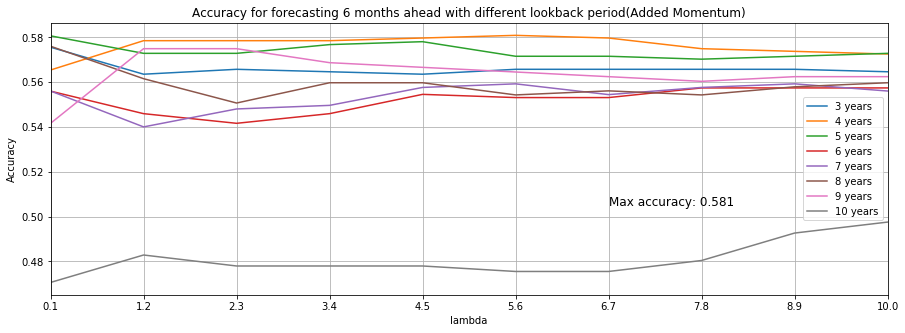

6
0.581


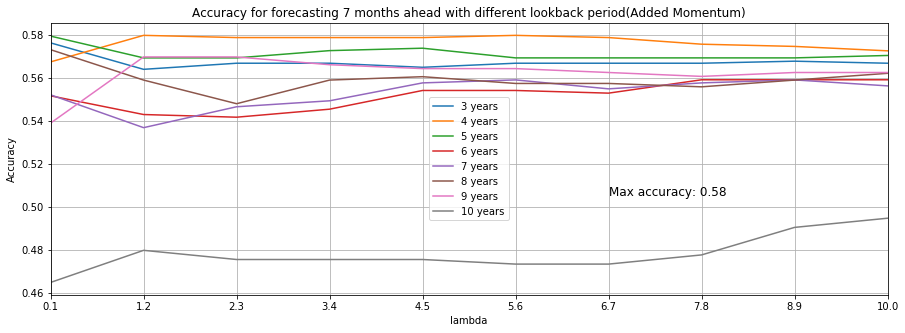

7
0.58


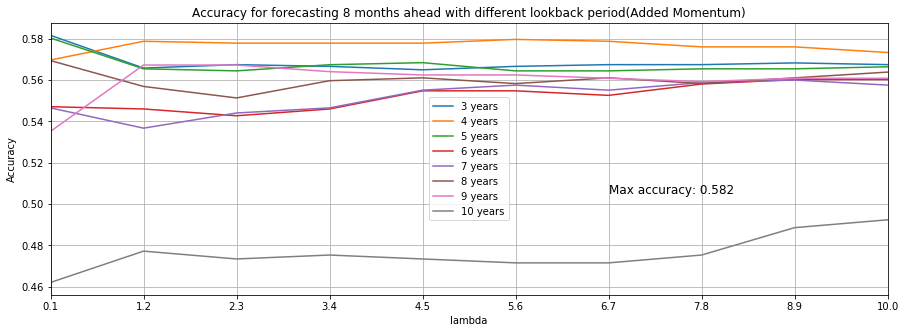

8
0.582


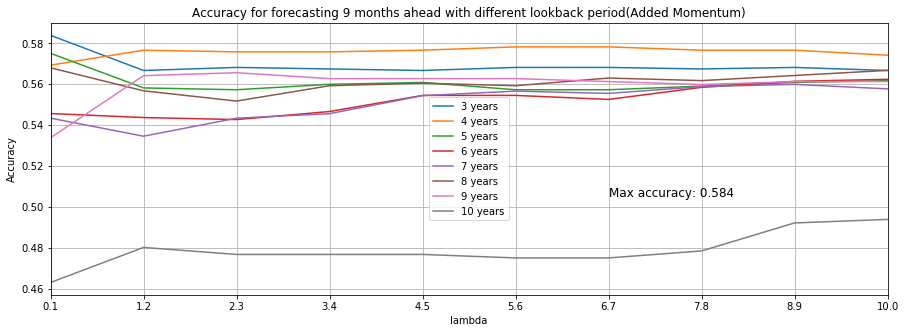

9
0.584


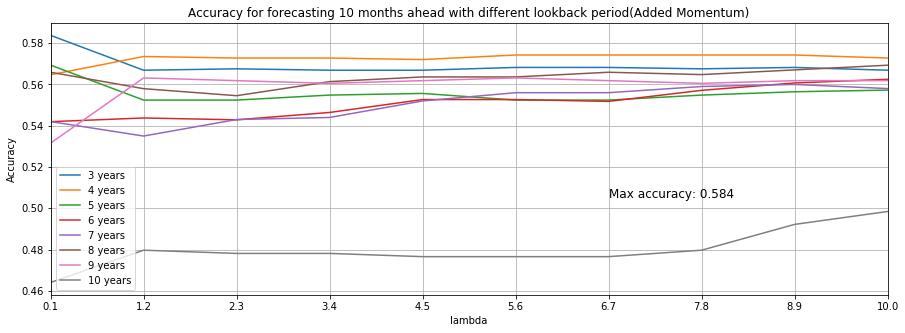

10
0.584


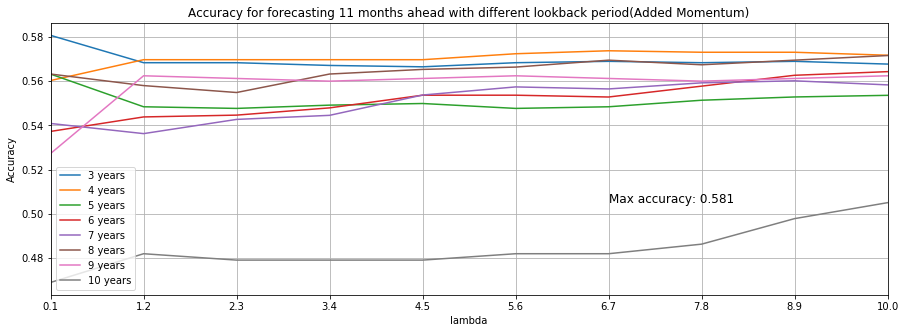

11
0.581


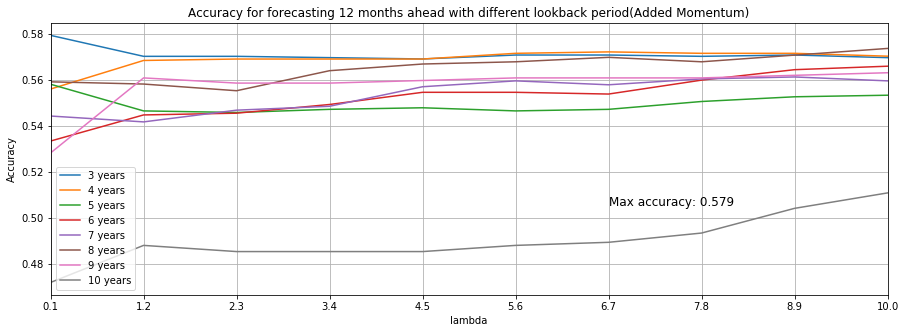

12
0.579


In [49]:
# x_data_momentum = pd.concat([equal_weight_momentum,x_data],1).resample("M").last().dropna()
# sector_beat_benchmarks = sector_beat_benchmarks.resample("M").last().dropna()
# x_data_momentum,sector_beat_benchmarks = model_data(x_data_momentum,sector_beat_benchmarks)
# for month in np.arange(3,12+1):
#     change_month_horizon(x_data_momentum,sector_beat_benchmarks,month,True,"Added Momentum")

In [47]:
import statsmodels.api as sm

In [132]:
x = x_data
y = sector_beat_benchmark
nunmber_of_years_lookback = 4
month_forecast = 3
lambda_value = 0.025


logistic_result_dict = {}
coef_all_df = pd.DataFrame()
accuracy_dict = {}
y_prediction_dict ={}
prob_dict ={}
number_of_runs = 0.0
use_statsmodels = False


list_of_index = x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]
for dt_index in list_of_index:
    begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
    selection = (x.index>=begin_index) & (x.index <= end_index)
    spliced_x = x[selection]
    spliced_y = y[selection]

    assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
    if use_statsmodels:
        logistic  = sm.Logit(spliced_y, sm.add_constant(spliced_x)).fit()

#         coef_df = pd.DataFrame(logistic.coef_,columns = spliced_x.columns,index = [dt_index])
#         coef_all_df = pd.concat([coef_all_df,coef_df])
    else:
        logistic  = LogisticRegression(penalty='l2', C = 1/float(lambda_value))
        logistic.fit(spliced_x,spliced_y)
        coef_df = pd.DataFrame(logistic.coef_,columns = spliced_x.columns,index = [dt_index])
        coef_all_df = pd.concat([coef_all_df,coef_df])
    
    test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
    test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
    test_x = x[test_selection]
    test_y = y[test_selection]
    assert(len(test_y)==month_forecast)
    if use_statsmodels:
        None
    else:
        y_prediction = pd.DataFrame(logistic.predict(test_x),index = test_y.index,columns = test_y.columns)
        prb_values = [prob_list[1] for prob_list in logistic.predict_proba(test_x)]
        prob_dict[str(dt_index.date())]=pd.DataFrame(prb_values, index = test_y.index)
    y_prediction_dict[dt_index] = y_prediction
    accuracy_df = ((y_prediction-test_y)==0)*1
    accuracy_dict[str(dt_index.date())] = accuracy_df
    number_of_runs +=1
print(number_of_runs)
mean_accuracy_list = []
for key,value in accuracy_dict.iteritems():
    mean_accuracy_list.append((value.values.flatten()))
    
concat_df = pd.DataFrame()
for key in np.sort(prob_dict.keys()):
    value = prob_dict[key]
    concat_df = pd.concat([concat_df,value],1)
clean_df = pd.DataFrame()
for index in concat_df.index:
    temp = concat_df.loc[index,:].dropna()
    temp = pd.DataFrame(temp).T
    temp.columns = range(len(temp.columns))
    clean_df = pd.concat([clean_df,temp])

147.0


In [124]:
# logistic.pvalues

In [125]:
# logistic.summary()

In [126]:
# np.concatenate([logistic.intercept_,logistic.coef_[0]])

In [157]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p,se

In [158]:
logit_pvalue(logistic,spliced_x.as_matrix())

(array([ 0.991792  ,  0.99590534,  0.99865748,  0.99980397,  0.99865907,
         0.99996608,  0.31898303,  0.9976176 ,  0.99996289,  0.9912486 ,
         0.99968232,  0.99875263,  0.99999977,  0.96171513,  0.93217431,
         0.58516855,  0.98901066,  0.99315955,  0.98847068,  0.86982611,
         0.9949875 ,  0.99890961,  0.99754904,  0.99856894,  0.96075726,
         0.89860191]),
 array([  8.84443105e+00,   1.02160337e+02,   4.66006300e+02,
          8.32270481e+02,   5.66085406e+02,   9.47788479e+02,
          1.76068412e+00,   8.07856975e+01,   3.10432198e+02,
          1.01824592e+02,   8.10222240e+02,   1.80039556e+02,
          6.64073868e+03,   1.78839993e+01,   1.12459597e+01,
          1.06006438e+01,   1.25439952e+01,   3.72178222e+01,
          3.96877630e+01,   2.45384011e+01,   1.01175777e+02,
          9.44200964e+01,   1.18677004e+02,   2.11634616e+02,
          2.23236513e+01,   2.12788345e+01]))

In [36]:
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
model = LogisticRegression(C=1e30).fit(x, y)
print(logit_pvalue(model, x))

[ 0.11413093  0.08779978]


In [37]:
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

[ 0.11413093  0.08779979]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                          Logit   Df Residuals:                        8
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:                  0.4856
Time:                        11:23:29   Log-Likelihood:                -3.5656
converged:                       True   LL-Null:                       -6.9315
                                        LLR p-value:                  0.009472
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9587      2.506     -1.580      0.114      -8.870       0.952
x1             0.8797      0.515      1.707      0.088      -0.130       1.890
==============================================================================
"""

In [133]:
clean_df

,0,1,2
2004-12-31,0.497440,NaN,NaN
2005-01-31,0.394049,0.386543,NaN
2005-02-28,0.567868,0.578218,0.555668
2005-03-31,0.613998,0.606902,0.563633
2005-04-30,0.438523,0.393625,0.421111
2005-05-31,0.578011,0.575530,0.576569
2005-06-30,0.429242,0.447073,0.464848
2005-07-31,0.455189,0.459907,0.432660
2005-08-31,0.477707,0.463022,0.415652
2005-09-30,0.679724,0.654507,0.598056


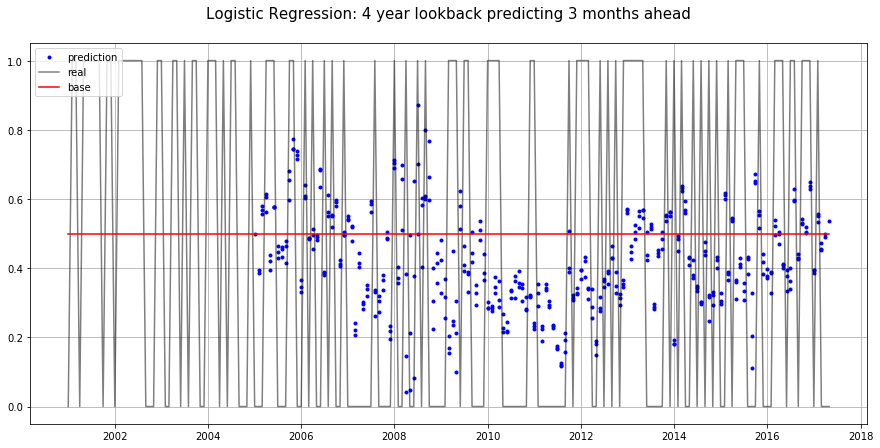

In [142]:
plt.figure(figsize = (15,7))
plt.grid()
pred_1,pred_2,pred_3,=plt.plot(clean_df,'b.')
real_y,=plt.plot(y,'k-',alpha = 0.5)
base,=plt.plot(y.index,np.repeat(0.5,len(y)),'r-')
plt.legend([pred_1,real_y,base],['prediction','real','base'],loc=2)
ttl = plt.title("Logistic Regression: 4 year lookback predicting 3 months ahead",fontsize = 15)
ttl.set_position([.5, 1.05])
plt.savefig(logistic_png_dir+"Logistic_regression_4year_3months_result.png",bbox_inches='tight')
plt.show()

In [156]:
logistic_png_dir+"Logistic_regression_4year_3months_close_up_result.png"

'/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/logistic_png/Logistic_regression_4year_3months_close_up_result.png'

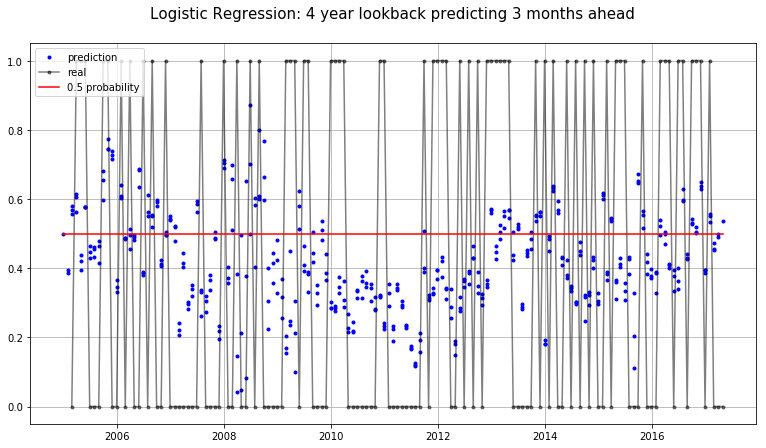

In [155]:
common_index = pd.concat([clean_df,y],1).resample("M").last().dropna().index

plt.figure(figsize = (13,7))
plt.grid()
pred_1,pred_2,pred_3,=plt.plot(clean_df,'b.')
real_y,=plt.plot(y.loc[common_index[0]:,:],'k.-',alpha = 0.5)
base,=plt.plot(clean_df.index,np.repeat(0.5,len(clean_df)),'r-')
plt.legend([pred_1,real_y,base],['prediction','real','0.5 probability'],loc=2)
ttl = plt.title("Logistic Regression: 4 year lookback predicting 3 months ahead",fontsize = 15)
ttl.set_position([.5, 1.05])
plt.savefig(logistic_png_dir+"Logistic_regression_4year_3months_close_up_result.png",bbox_inches='tight')
plt.show()

In [22]:
market_cap_weight_momentum,x_data = model_data(market_cap_weight_momentum,x_data)

In [23]:
market_cap_weight_momentum.resample("M").last().dropna().index

DatetimeIndex(['2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31',
               '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30',
               '2001-12-31', '2002-01-31',
               ...
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30'],
              dtype='datetime64[ns]', length=192, freq=None)

In [24]:
x_data.resample("M").last().dropna().index

DatetimeIndex(['2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31',
               '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30',
               '2001-12-31', '2002-01-31',
               ...
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30'],
              dtype='datetime64[ns]', length=192, freq=None)

/home/luke/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


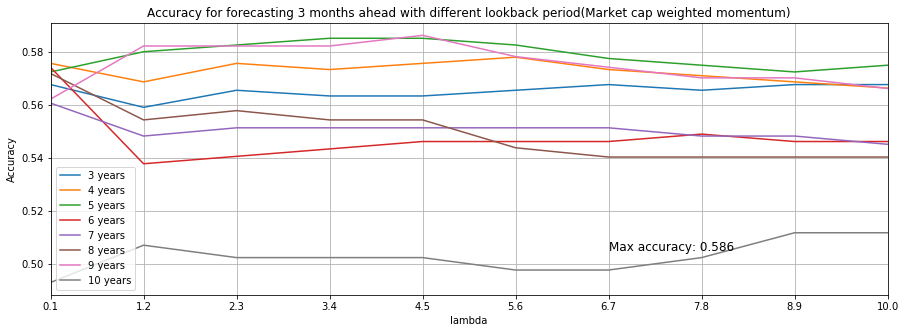

3
0.586


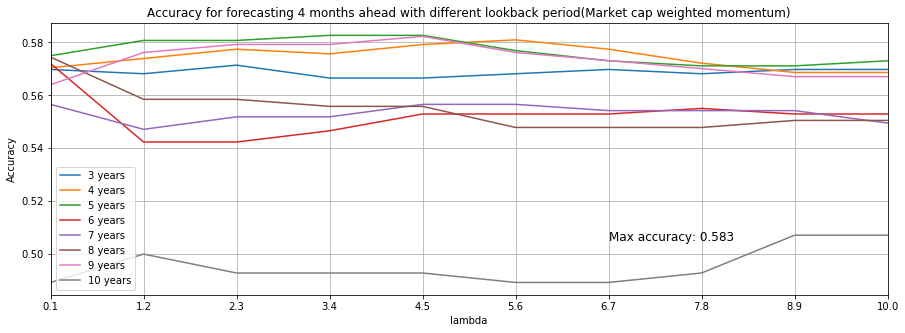

4
0.583


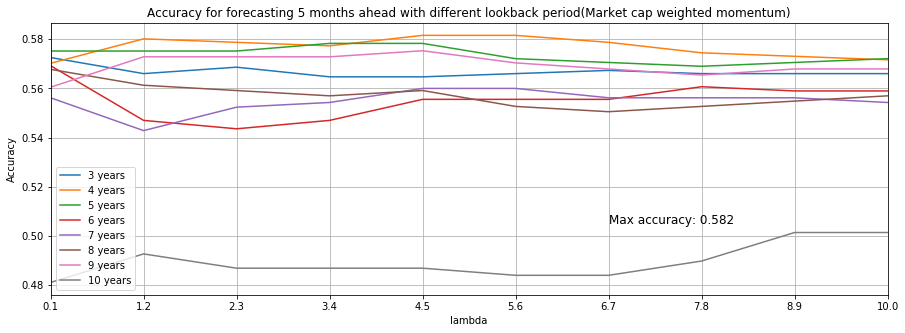

5
0.582


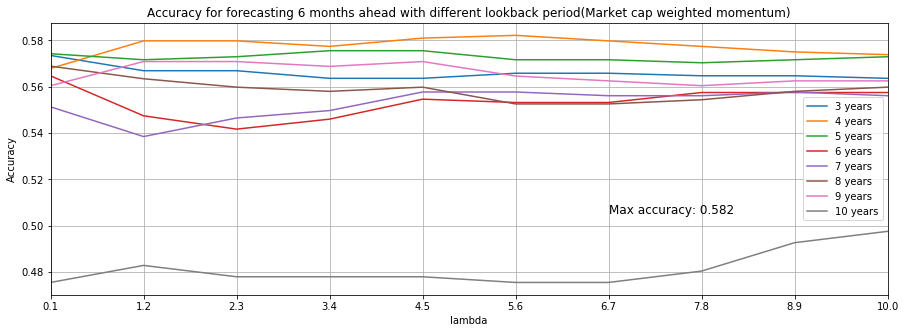

6
0.582


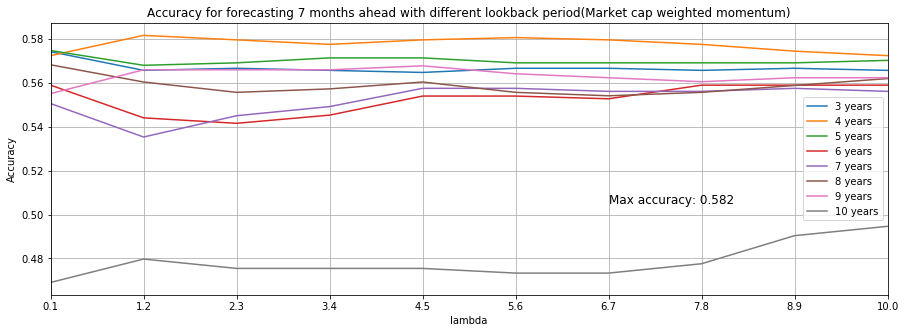

7
0.582


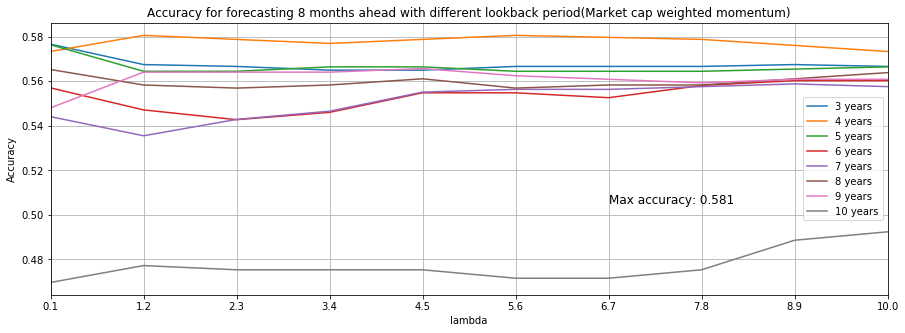

8
0.581


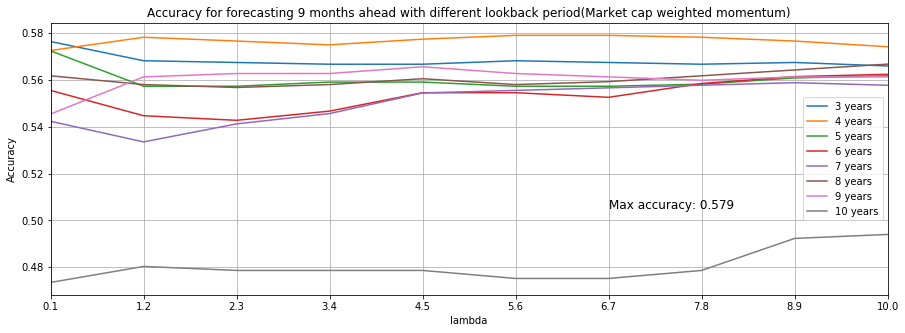

9
0.579


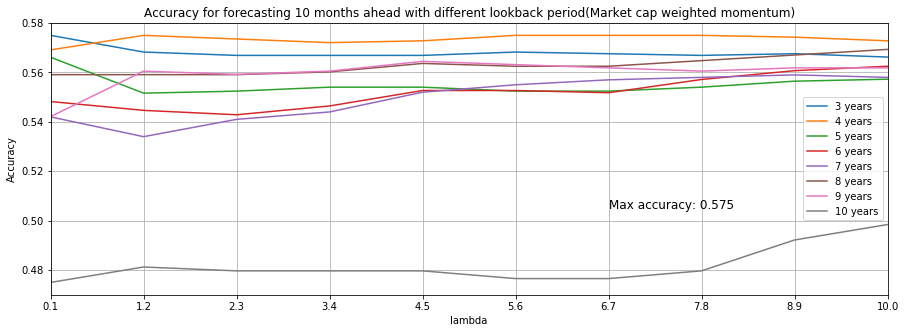

10
0.575


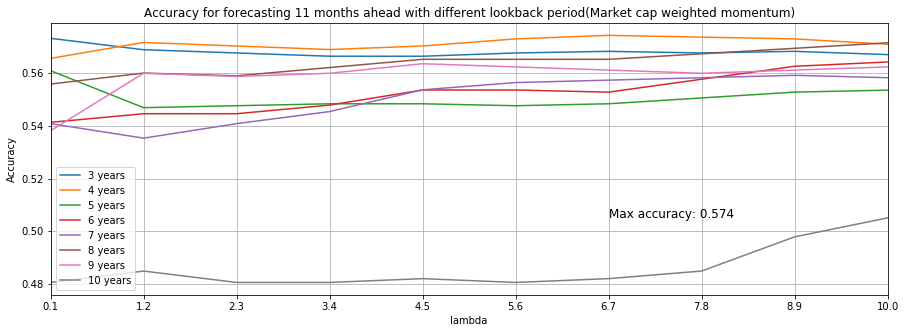

11
0.574


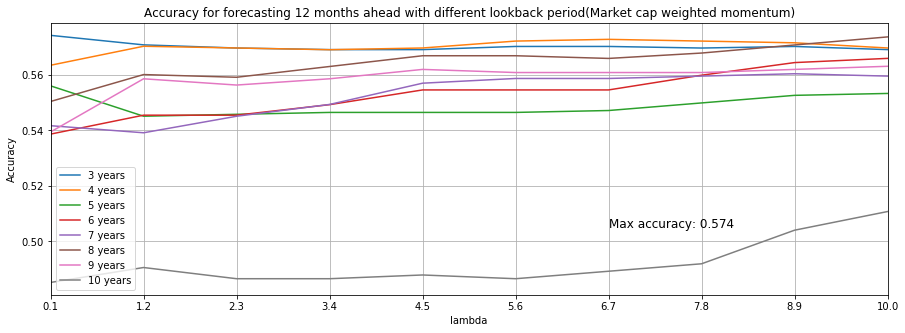

12
0.574


In [9]:
x_data_cap_momentum = pd.concat([market_cap_weight_momentum,x_data],1).resample("M").last().dropna()
x_data_cap_momentum,sector_beat_benchmarks = model_data(x_data_cap_momentum,sector_beat_benchmarks)
for month in np.arange(3,12+1):
    change_month_horizon(x_data_cap_momentum,sector_beat_benchmarks,month,True,'Market cap weighted momentum')

In [11]:
%store -r price_momentum

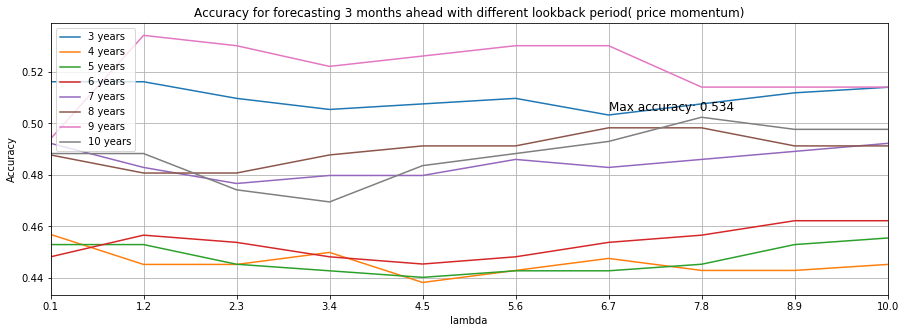

3
0.534


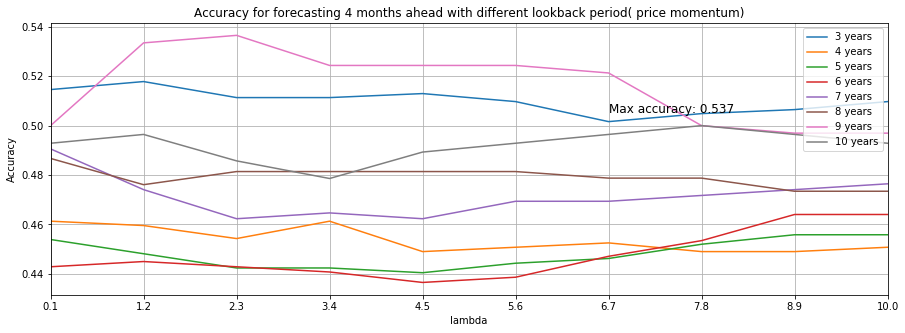

4
0.537


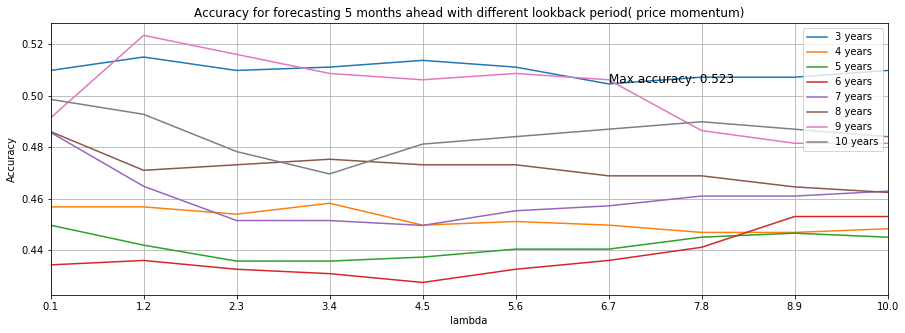

5
0.523


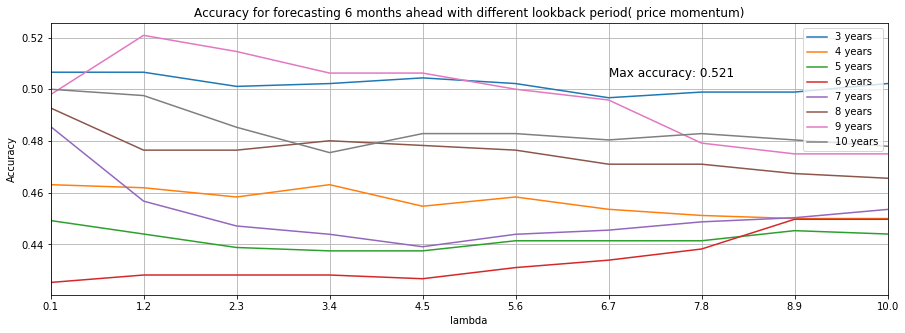

6
0.521


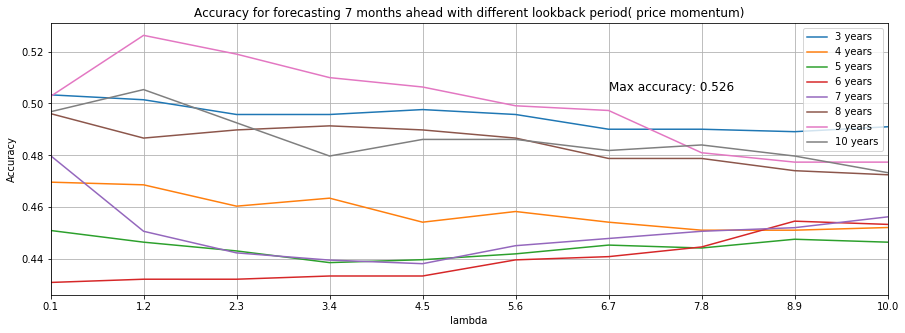

7
0.526


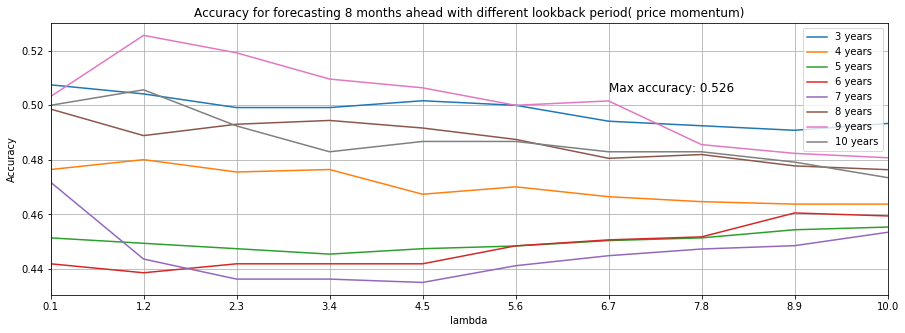

8
0.526


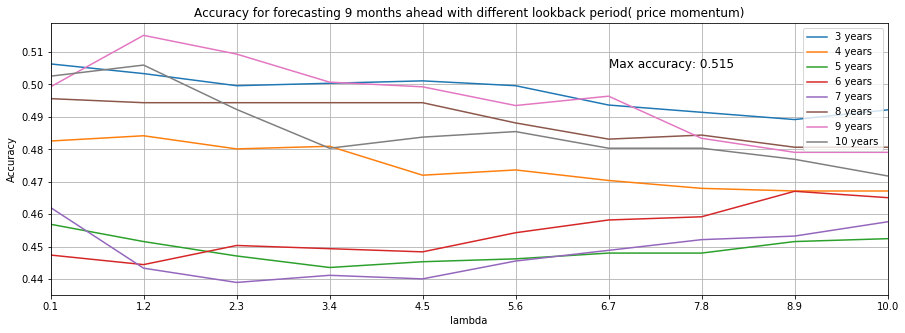

9
0.515


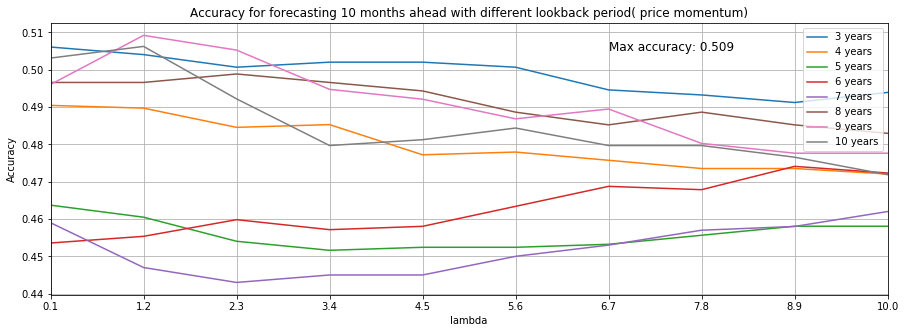

10
0.509


In [12]:
x_data_price_momentum = pd.concat([price_momentum,x_data],1).resample("M").last().dropna()
x_data_price_momentum,sector_beat_benchmarks = model_data(x_data_price_momentum,sector_beat_benchmarks)
for month in np.arange(3,10+1):
    change_month_horizon(x_data_price_momentum,sector_beat_benchmarks,month,True,' price momentum')